In [1]:
import os
import cv2
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from geopandas import GeoSeries
from shapely.geometry import Polygon
from rasterio.windows import Window
from rasterio.plot import reshape_as_image

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Flatten, Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
%matplotlib inline

2022-08-04 13:35:58.482855: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ymi/.virtualenvs/ws/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-04 13:35:58.482880: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# read the labels dataframe
farmpin_data = pd.read_csv("/home/ymi/data/ucu_data/Farmpin_training.csv")

In [5]:
farmpin_data['crop_id'].value_counts()

8    943
4    536
5    283
7    267
6    147
1    142
3     95
9     77
2      7
Name: crop_id, dtype: int64

In [6]:
# find all images
dataset = os.listdir("/home/ymi/data/ucu_data/images_cropped_rgb")
farmIds = [int(img_name.split(".")[0]) for img_name in dataset]

In [11]:
# prepare the data
for num, row in farmpin_data.iterrows():
    img_path = os.path.join("/home/ymi/data/ucu_data/images_cropped_rgb", str(row['field_id']) + ".jpg")
    img = cv2.imread(img_path)
    if isinstance(img, np.ndarray):
        farmpin_data.loc[num, 'img_path'] = img_path
        farmpin_data.loc[num, 'size'] = img.shape[0] * img.shape[1]

[ WARN:0@265.477] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/1.jpg'): can't open/read file: check file path/integrity
[ WARN:0@265.482] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/2.jpg'): can't open/read file: check file path/integrity
[ WARN:0@265.484] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/3.jpg'): can't open/read file: check file path/integrity
[ WARN:0@265.485] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/4.jpg'): can't open/read file: check file path/integrity
[ WARN:0@265.487] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/7.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2

[ WARN:0@265.679] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/287.jpg'): can't open/read file: check file path/integrity
[ WARN:0@265.679] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/288.jpg'): can't open/read file: check file path/integrity
[ WARN:0@265.680] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/289.jpg'): can't open/read file: check file path/integrity
[ WARN:0@265.680] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/290.jpg'): can't open/read file: check file path/integrity
[ WARN:0@265.680] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/293.jpg'): can't open/read file: check file path/integrity


[ WARN:0@267.549] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/2662.jpg'): can't open/read file: check file path/integrity
[ WARN:0@267.549] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/2666.jpg'): can't open/read file: check file path/integrity
[ WARN:0@267.712] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/2880.jpg'): can't open/read file: check file path/integrity
[ WARN:0@267.712] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/2881.jpg'): can't open/read file: check file path/integrity
[ WARN:0@267.713] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/ymi/data/ucu_data/images_cropped_rgb/2883.jpg'): can't open/read file: check file path/integ

<AxesSubplot:>

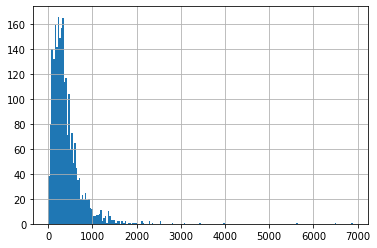

In [15]:
farmpin_data['size'].hist(bins=200)

In [16]:
# filter fields with area higher than 15 pixels 

farmpin_data.dropna(inplace=True)

farmpin_data['size'].min()

farmpin_data = farmpin_data[farmpin_data['size'] >= 15]

In [17]:
len(farmpin_data)

2359

In [18]:
# prepare y labels
farmpin_data['crop_id'] = farmpin_data['crop_id'] - 1

y = to_categorical(farmpin_data['crop_id'].tolist(), num_classes = 9)

/tmp/ipykernel_177573/1633791195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  farmpin_data['crop_id'] = farmpin_data['crop_id'] - 1


In [20]:
y.shape

(2359, 9)

In [21]:
def load_image(img_path):
      
    img = cv2.imread(img_path)

    return img

In [22]:
def crop_image(image, w, h):
    center = np.array(image.shape) / 2
    x = int(center[1] - w/2)
    y = int(center[0] - h/2)
    crop_img = image[int(y):int(y+h), int(x):int(x+w), :]
    return crop_img

In [23]:
#generate X
def generate_X(img_list, w, h):
    input_size = int(w * h * 3)
    X = np.empty((len(img_list), input_size))

    for i, item in enumerate(img_list):
        img = load_image(item)
        # print(img.shape)
        if img.shape[0] > h and img.shape[1] > h:
            img = crop_image(img, w, h)
        img = img.flatten()
        if img.shape[0] > input_size:
            img = img[:input_size]
        X[i,] = img
    
    # normalize 
    X = X / 127.5
    X -= 1.0
    return X


In [50]:
X_train = generate_X(farmpin_data['img_path'], 16, 16)
X_train.shape

ValueError: could not broadcast input array from shape (759,) into shape (768,)

In [29]:
y.shape

(2359, 9)

In [31]:
Model

keras.engine.training.Model

In [32]:
def build_model_dense(input_shape, num_classes):
    inputs = Input(input_shape)
    
    # 32 layers with sigmoid activation
    # 16 layers
    # output with softmax activation
    hidden_1 = Dense(32, activation = 'relu')(inputs)
    hidden_2 = Dense(16, activation = 'relu')(hidden_1)
    outputs = Dense(num_classes, activation = 'softmax')(hidden_2)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    return model


In [33]:
# create model with input 48 and output 9

classification_model = build_model_dense(48, 9)

2022-08-04 13:50:59.567751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ymi/.virtualenvs/ws/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-04 13:50:59.567800: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-04 13:50:59.567836: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (machine): /proc/driver/nvidia/version does not exist
2022-08-04 13:50:59.568100: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
classification_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                1568      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 153       
Total params: 2,249
Trainable params: 2,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# check model summary 

In [36]:
y.shape

(2359, 9)

In [35]:

model_checkpoint = ModelCheckpoint("model_class.hdf5", save_best_only=True, verbose=1, monitor='accuracy', mode='max')

In [ ]:
# compile model with tf.keras.optimizers.Adam(0.001), loss tf.keras.losses.CategoricalCrossentropy(from_logits=False), tf.keras.metrics.CategoricalAccuracy()]

In [37]:
classification_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                             metrics=tf.keras.metrics.CategoricalAccuracy())

In [38]:
# fit model
classification_model.fit(X_train,
          y,
          batch_size=256, 
          epochs=1000,
          verbose=1,
          callbacks=[model_checkpoint])

2022-08-04 13:55:27.903884: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
10/10 [==============================] - 1s 3ms/step - loss: 1.9470 - categorical_accuracy: 0.3832
Epoch 2/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.8345 - categorical_accuracy: 0.3832
Epoch 3/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.7606 - categorical_accuracy: 0.3832
Epoch 4/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.7156 - categorical_accuracy: 0.3828
Epoch 5/1000
10/10 [==============================] - 0s 7ms/step - loss: 1.7020 - categorical_accuracy: 0.3828
Epoch 6/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.6948 - categorical_accuracy: 0.3841
Epoch 7/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.6877 - categorical_accuracy: 0.3858
Epoch 8/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.6816 - categorical_accuracy: 0.3883
Epoch 9/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.6761 - categorical_accuracy:

Epoch 44/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.5592 - categorical_accuracy: 0.4663
Epoch 45/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.5580 - categorical_accuracy: 0.4633
Epoch 46/1000
10/10 [==============================] - 0s 8ms/step - loss: 1.5577 - categorical_accuracy: 0.4655
Epoch 47/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.5539 - categorical_accuracy: 0.4663
Epoch 48/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.5541 - categorical_accuracy: 0.4646
Epoch 49/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.5507 - categorical_accuracy: 0.4697
Epoch 50/1000
10/10 [==============================] - 0s 7ms/step - loss: 1.5496 - categorical_accuracy: 0.4650
Epoch 51/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.5510 - categorical_accuracy: 0.4850
Epoch 52/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.5487 - categorical_

Epoch 87/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.5047 - categorical_accuracy: 0.4972
Epoch 88/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.5044 - categorical_accuracy: 0.4977
Epoch 89/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.5042 - categorical_accuracy: 0.4862
Epoch 90/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.5020 - categorical_accuracy: 0.4926
Epoch 91/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.5003 - categorical_accuracy: 0.4968
Epoch 92/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4996 - categorical_accuracy: 0.4989
Epoch 93/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4999 - categorical_accuracy: 0.4955
Epoch 94/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4977 - categorical_accuracy: 0.4968
Epoch 95/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.5016 - categorical_

10/10 [==============================] - 0s 4ms/step - loss: 1.4659 - categorical_accuracy: 0.5061
Epoch 130/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4652 - categorical_accuracy: 0.5078
Epoch 131/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4635 - categorical_accuracy: 0.5049
Epoch 132/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.4624 - categorical_accuracy: 0.5074
Epoch 133/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4610 - categorical_accuracy: 0.5100
Epoch 134/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4597 - categorical_accuracy: 0.5121
Epoch 135/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4597 - categorical_accuracy: 0.5070
Epoch 136/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.4586 - categorical_accuracy: 0.5091
Epoch 137/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4581 - categorical_accura

10/10 [==============================] - 0s 4ms/step - loss: 1.4287 - categorical_accuracy: 0.5155
Epoch 172/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4233 - categorical_accuracy: 0.5214
Epoch 173/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4342 - categorical_accuracy: 0.5142
Epoch 174/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.4345 - categorical_accuracy: 0.5125
Epoch 175/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.4261 - categorical_accuracy: 0.5210
Epoch 176/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.4242 - categorical_accuracy: 0.5256
Epoch 177/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.4272 - categorical_accuracy: 0.5210
Epoch 178/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.4224 - categorical_accuracy: 0.5184
Epoch 179/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.4193 - categorical_accura

10/10 [==============================] - 0s 4ms/step - loss: 1.3948 - categorical_accuracy: 0.5388
Epoch 214/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3940 - categorical_accuracy: 0.5316
Epoch 215/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3913 - categorical_accuracy: 0.5350
Epoch 216/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.3897 - categorical_accuracy: 0.5379
Epoch 217/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.3879 - categorical_accuracy: 0.5375
Epoch 218/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.3903 - categorical_accuracy: 0.5379
Epoch 219/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.3887 - categorical_accuracy: 0.5350
Epoch 220/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.3882 - categorical_accuracy: 0.5392
Epoch 221/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.3940 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.3709 - categorical_accuracy: 0.5396
Epoch 256/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3706 - categorical_accuracy: 0.5439
Epoch 257/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.3671 - categorical_accuracy: 0.5435
Epoch 258/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.3719 - categorical_accuracy: 0.5413
Epoch 259/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.3716 - categorical_accuracy: 0.5460
Epoch 260/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.3680 - categorical_accuracy: 0.5451
Epoch 261/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3665 - categorical_accuracy: 0.5439
Epoch 262/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3654 - categorical_accuracy: 0.5401
Epoch 263/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3729 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.3526 - categorical_accuracy: 0.5473
Epoch 298/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.3531 - categorical_accuracy: 0.5524
Epoch 299/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3538 - categorical_accuracy: 0.5447
Epoch 300/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.3533 - categorical_accuracy: 0.5447
Epoch 301/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.3544 - categorical_accuracy: 0.5426
Epoch 302/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3498 - categorical_accuracy: 0.5430
Epoch 303/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.3524 - categorical_accuracy: 0.5507
Epoch 304/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3545 - categorical_accuracy: 0.5456
Epoch 305/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.3535 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.3450 - categorical_accuracy: 0.5490
Epoch 340/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3436 - categorical_accuracy: 0.5536
Epoch 341/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3463 - categorical_accuracy: 0.5456
Epoch 342/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3442 - categorical_accuracy: 0.5494
Epoch 343/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.3418 - categorical_accuracy: 0.5502
Epoch 344/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.3407 - categorical_accuracy: 0.5536
Epoch 345/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3423 - categorical_accuracy: 0.5532
Epoch 346/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3414 - categorical_accuracy: 0.5515
Epoch 347/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3419 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.3288 - categorical_accuracy: 0.5553
Epoch 382/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3303 - categorical_accuracy: 0.5613
Epoch 383/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3301 - categorical_accuracy: 0.5536
Epoch 384/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3261 - categorical_accuracy: 0.5528
Epoch 385/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3250 - categorical_accuracy: 0.5574
Epoch 386/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3279 - categorical_accuracy: 0.5549
Epoch 387/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3295 - categorical_accuracy: 0.5570
Epoch 388/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3277 - categorical_accuracy: 0.5587
Epoch 389/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3258 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.3166 - categorical_accuracy: 0.5604
Epoch 424/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3182 - categorical_accuracy: 0.5549
Epoch 425/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3175 - categorical_accuracy: 0.5604
Epoch 426/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3147 - categorical_accuracy: 0.5600
Epoch 427/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3178 - categorical_accuracy: 0.5596
Epoch 428/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3156 - categorical_accuracy: 0.5634
Epoch 429/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3198 - categorical_accuracy: 0.5604
Epoch 430/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.3159 - categorical_accuracy: 0.5587
Epoch 431/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3179 - categorical_accura

10/10 [==============================] - 0s 2ms/step - loss: 1.3122 - categorical_accuracy: 0.5587
Epoch 466/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3127 - categorical_accuracy: 0.5642
Epoch 467/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3181 - categorical_accuracy: 0.5549
Epoch 468/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.3078 - categorical_accuracy: 0.5596
Epoch 469/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3073 - categorical_accuracy: 0.5642
Epoch 470/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3148 - categorical_accuracy: 0.5562
Epoch 471/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3186 - categorical_accuracy: 0.5540
Epoch 472/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.3080 - categorical_accuracy: 0.5659
Epoch 473/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.3077 - categorical_accura

10/10 [==============================] - 0s 4ms/step - loss: 1.3105 - categorical_accuracy: 0.5613
Epoch 508/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2992 - categorical_accuracy: 0.5613
Epoch 509/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.3007 - categorical_accuracy: 0.5642
Epoch 510/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.3076 - categorical_accuracy: 0.5596
Epoch 511/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.3041 - categorical_accuracy: 0.5583
Epoch 512/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3035 - categorical_accuracy: 0.5613
Epoch 513/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3010 - categorical_accuracy: 0.5651
Epoch 514/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.2995 - categorical_accuracy: 0.5651
Epoch 515/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.3001 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.2935 - categorical_accuracy: 0.5651
Epoch 550/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2939 - categorical_accuracy: 0.5642
Epoch 551/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2971 - categorical_accuracy: 0.5659
Epoch 552/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2996 - categorical_accuracy: 0.5680
Epoch 553/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2951 - categorical_accuracy: 0.5617
Epoch 554/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2942 - categorical_accuracy: 0.5642
Epoch 555/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2913 - categorical_accuracy: 0.5630
Epoch 556/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2914 - categorical_accuracy: 0.5685
Epoch 557/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2947 - categorical_accura

10/10 [==============================] - 0s 2ms/step - loss: 1.2892 - categorical_accuracy: 0.5685
Epoch 592/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2875 - categorical_accuracy: 0.5693
Epoch 593/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2880 - categorical_accuracy: 0.5634
Epoch 594/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2884 - categorical_accuracy: 0.5613
Epoch 595/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2861 - categorical_accuracy: 0.5719
Epoch 596/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2895 - categorical_accuracy: 0.5659
Epoch 597/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2855 - categorical_accuracy: 0.5621
Epoch 598/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2852 - categorical_accuracy: 0.5659
Epoch 599/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2885 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.2812 - categorical_accuracy: 0.5719
Epoch 634/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2831 - categorical_accuracy: 0.5706
Epoch 635/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2841 - categorical_accuracy: 0.5693
Epoch 636/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2841 - categorical_accuracy: 0.5706
Epoch 637/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2845 - categorical_accuracy: 0.5714
Epoch 638/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2877 - categorical_accuracy: 0.5706
Epoch 639/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2812 - categorical_accuracy: 0.5697
Epoch 640/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2851 - categorical_accuracy: 0.5676
Epoch 641/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2796 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.2753 - categorical_accuracy: 0.5731
Epoch 676/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2790 - categorical_accuracy: 0.5702
Epoch 677/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2781 - categorical_accuracy: 0.5689
Epoch 678/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2810 - categorical_accuracy: 0.5748
Epoch 679/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2750 - categorical_accuracy: 0.5710
Epoch 680/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2739 - categorical_accuracy: 0.5727
Epoch 681/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2811 - categorical_accuracy: 0.5714
Epoch 682/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2792 - categorical_accuracy: 0.5727
Epoch 683/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2753 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.2675 - categorical_accuracy: 0.5803
Epoch 718/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2659 - categorical_accuracy: 0.5761
Epoch 719/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2676 - categorical_accuracy: 0.5782
Epoch 720/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2689 - categorical_accuracy: 0.5829
Epoch 721/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2713 - categorical_accuracy: 0.5786
Epoch 722/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2805 - categorical_accuracy: 0.5719
Epoch 723/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2876 - categorical_accuracy: 0.5680
Epoch 724/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2800 - categorical_accuracy: 0.5735
Epoch 725/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2661 - categorical_accura

10/10 [==============================] - 0s 4ms/step - loss: 1.2772 - categorical_accuracy: 0.5765
Epoch 760/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2649 - categorical_accuracy: 0.5761
Epoch 761/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2627 - categorical_accuracy: 0.5782
Epoch 762/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2709 - categorical_accuracy: 0.5727
Epoch 763/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2630 - categorical_accuracy: 0.5816
Epoch 764/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2658 - categorical_accuracy: 0.5774
Epoch 765/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2703 - categorical_accuracy: 0.5774
Epoch 766/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2779 - categorical_accuracy: 0.5735
Epoch 767/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2749 - categorical_accura

10/10 [==============================] - 0s 4ms/step - loss: 1.2562 - categorical_accuracy: 0.5875
Epoch 802/1000
10/10 [==============================] - 0s 5ms/step - loss: 1.2591 - categorical_accuracy: 0.5854
Epoch 803/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2564 - categorical_accuracy: 0.5854
Epoch 804/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2657 - categorical_accuracy: 0.5765
Epoch 805/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2599 - categorical_accuracy: 0.5803
Epoch 806/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2576 - categorical_accuracy: 0.5846
Epoch 807/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2710 - categorical_accuracy: 0.5740
Epoch 808/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2590 - categorical_accuracy: 0.5812
Epoch 809/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2581 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.2571 - categorical_accuracy: 0.5808
Epoch 844/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2575 - categorical_accuracy: 0.5799
Epoch 845/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2541 - categorical_accuracy: 0.5774
Epoch 846/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2544 - categorical_accuracy: 0.5854
Epoch 847/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2537 - categorical_accuracy: 0.5850
Epoch 848/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2613 - categorical_accuracy: 0.5757
Epoch 849/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2517 - categorical_accuracy: 0.5854
Epoch 850/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2523 - categorical_accuracy: 0.5837
Epoch 851/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2551 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.2483 - categorical_accuracy: 0.5914
Epoch 886/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2503 - categorical_accuracy: 0.5799
Epoch 887/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2550 - categorical_accuracy: 0.5863
Epoch 888/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2563 - categorical_accuracy: 0.5757
Epoch 889/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2528 - categorical_accuracy: 0.5765
Epoch 890/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2499 - categorical_accuracy: 0.5850
Epoch 891/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2527 - categorical_accuracy: 0.5863
Epoch 892/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2515 - categorical_accuracy: 0.5863
Epoch 893/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2543 - categorical_accura

10/10 [==============================] - 0s 3ms/step - loss: 1.2444 - categorical_accuracy: 0.5850
Epoch 928/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2442 - categorical_accuracy: 0.5871
Epoch 929/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2433 - categorical_accuracy: 0.5888
Epoch 930/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2528 - categorical_accuracy: 0.5812
Epoch 931/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2458 - categorical_accuracy: 0.5829
Epoch 932/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2443 - categorical_accuracy: 0.5837
Epoch 933/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2455 - categorical_accuracy: 0.5846
Epoch 934/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2442 - categorical_accuracy: 0.5875
Epoch 935/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2447 - categorical_accura

10/10 [==============================] - 0s 2ms/step - loss: 1.2419 - categorical_accuracy: 0.5825
Epoch 970/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2409 - categorical_accuracy: 0.5871
Epoch 971/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2429 - categorical_accuracy: 0.5892
Epoch 972/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2452 - categorical_accuracy: 0.5858
Epoch 973/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2379 - categorical_accuracy: 0.5880
Epoch 974/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2395 - categorical_accuracy: 0.5901
Epoch 975/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.2410 - categorical_accuracy: 0.5875
Epoch 976/1000
10/10 [==============================] - 0s 3ms/step - loss: 1.2395 - categorical_accuracy: 0.5892
Epoch 977/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.2416 - categorical_accura

In [39]:
classification_model

In [41]:
np.expand_dims(X_train[0], 0).shape

(1, 48)

In [44]:
# predict X_train
prediction = classification_model.predict(X_train)

In [46]:
prediction.shape

(2359, 9)

In [47]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

<AxesSubplot:>

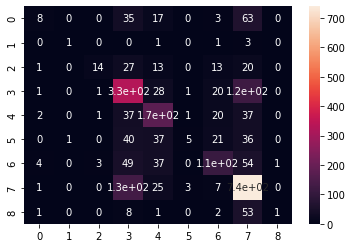

In [49]:
conf_matrix = confusion_matrix(farmpin_data['crop_id'].tolist(), np.argmax(prediction, axis=1))
sns.heatmap(conf_matrix, annot=True)

In [ ]:
# task create train, val, test split 
# train model with X_train, y_train, X_val, y_val
# and predict on X_test, y_test